In [1]:
# storia più su nns convolutive, capsulenetwork, evoluzione, problemi di classificazione





# usare affnist



# prova minst su affnist e verificare risultati con paper
# testare su dataset normale + rotraslato*2
# clustering per training
# risultato si su db normale sia rototraslato
#
# + provare no shearing


# matrice di confusione normalizzata sia su righe che su colonne (tot 3 matrici)

### Import statements

In [2]:
%%capture

import numpy as np
import tensorflow as tf
from datetime import datetime

# for affine transformation functions
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
import torch
import math

# for loading affNIST_original
import scipy.io as spio

#for training progress bar
from tqdm import tqdm

#for image display
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# for performances functions
from numpy import sqrt 
import seaborn as sns
import pandas as pd

#mandatory for correct load and save of files
%cd /Users/paolobonomi/Work/Python/CapsNetwork

# for project class
import sys
sys.path.append("/Users/paolobonomi/Work/Python/CapsNetwork/src")
from setup import Setup

### Retrieve model and dataset

In [3]:
pippo = Setup()
print(type(pippo))
model = pippo.get_model()
print(type(model))
X_train, y_train = pippo.get_train_images()
print(type(X_train))
X_test, y_test = pippo.get_test_images()

Found GPU at: /device:GPU:0Metal device set to: Apple M1

Load Custom affNIST train dataset _v1... 
Load Custom affNIST test dataset _v1... 
Processing dataset... 


2022-10-20 18:01:37.164941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 18:01:37.165013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-20 18:01:37.337036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 18:01:37.337057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Creating model... 
Loading model... 


2022-10-20 18:01:37.978103: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-20 18:01:37.978171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-20 18:01:40.731737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<class 'setup.Setup'>
<class 'capsuleNetwork_v2.CapsuleNetwork'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


### Performance Analizying Functions

In [4]:
headers = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

def get_confusion_table_for(mat, digit, tot):
    
    dict_ = {}
    
    # condition positive (how many images were < digit >)
    p = 0
    for i in range(0, 10):
        p += mat[i, digit]
    dict_["Condition Positive"] = p
    
    #condition negative (how many images were not < digit > )
    n = tot - p
    dict_["Condition Negative"] = n 
    
    tp = mat[digit, digit]
    dict_["True Positive (TN)"] = tp
    
    fn = -tp
    for i in range(0, 10):
        fn += mat[i, digit]
    dict_["False Negative (FN)"] = fn
    
    fp = -tp
    for i in range(0, 10):
        fp += mat[digit, i]
    dict_["False Positive (FP)"] = fp 
    
    tn = tot + tp    
    for i in range(0, 10):
        tn -= mat[digit, i] + mat[i, digit]
    dict_["True Negative (TN)"] = tn 

    tpr = tp / p
    dict_["Sensitivity (TPR)"] = tpr 

    tnr = tn / n
    dict_["Specificity (TNR)"] = tnr 

    ppv = tp / (tp + fp)
    dict_["Positive Predictive Value (PPV)"] = ppv

    npv = tn / ( tn + fn )
    dict_["Negative Predictive Value (NPV)"] = npv 

    fnr = 1 - tpr
    dict_["False Negative Rate (FNR)"] = fnr 

    fpr = 1 - tnr
    dict_["False Positive Rate (FPR)"] = fpr 

    fdr = 1 - ppv
    dict_["False Discovery Rate (FDR)"] = fdr 

    for_ = 1 - npv
    dict_["False Omission Rate (FOR)"] = for_ 

    lr_p = tpr/fpr
    dict_["Positive Likelihood Ratio (LR+)"] = int(lr_p) 
    
    lr_n = fnr/tnr
    dict_["Negative Likelihood Ratio (LR-)"] = lr_n 

    pt = sqrt( fpr ) / ( sqrt(tpr) * sqrt(fpr) )
    dict_["Prevalence Threshold (PT)"] = pt 

    ts = tp / ( tp + fn + fp )
    dict_["Threat Score"] = ts 

    prevalence = p / tot
    dict_["Prevalence"] = prevalence 
    
    acc = ( tp + tn ) / tot
    dict_["Accuracy (ACC)"] = acc 

    ba = ( tpr * tnr ) / 2
    dict_["Balanced Accuracy"] = ba 

    f1 = ( 2*tp ) / ( 2*tp + fp + fn )
    dict_["F1 Score"] = f1 

    mcc = ( ( tp * tn ) - ( fp * fn ) ) / sqrt( ( tp+fp )*( tp*fn )*( tn+fp )*(tn+fn) )
    dict_["Matthews Correlation Coefficient (MCC)"] = mcc
    
    fm = sqrt( ppv * tpr )
    dict_["Fowlkes–Mallows Index (FM)"] = fm
    
    bm = tpr + tnr - 1
    dict_["Bookmaker Informedness (BM)"] = bm
    
    mk = ppv + npv - 1
    dict_["Markedness (MK)"] = mk
    
    #from 0 to inf
    dor = lr_p / lr_n
    dict_["Diagnostic odds ratio (DOR)"] = int(dor)
    
    header = np.array(list(dict_.keys()))
    values = np.array(list(dict_.values()))
    
    return values, header

def get_accuracy(matrix):
    a = 0        
    for i in range(0, 10):        
        a += matrix[i, i]
    
    return a

def get_confusion_mat(predict_function, model, data, name):
    matrix = np.zeros((10,10))
    
    with tqdm(total=len(data)) as pbar:
        
        description = "Creating "+name+" confusion matrix"
        pbar.set_description_str(description)
        for X_batch, y_batch in data:
            
            res = predict_function(model, X_batch)
            for i in range(0, y_batch.shape[0]):
                
                matrix[y_batch[i], res[i]] += 1 # row, col
        
            pbar.update(1)

    return matrix

def normalize_matrix(matrix, tot):
    mat = matrix.copy()
    for i in range(0, 10):
        for j in range(0, 10):
            mat[i, j] = (mat[i, j] / tot) * 100  
    return mat

def print_eval_params(mat):
    
    tot_in = 0
    tot_out = 0
    
    for j in range(0, 10):
        digit = j
        
        v = 0
        for i in range(0, 10):
            v += mat[digit, i]
        k = mat[digit, digit]
        tot_out += (k/v)
        r = (k/v)*100
        
        
        #the model has predict digit v times, k of that was right
        #osservo l'output, qual'è la probabilità che il modello abbia classificato in modo corretto?
        print("Proportion of digit < "+str(digit)+" > that was correctly identified =\t\t"+str(r)+"%") #sommo sulla riga

        v = 0
        for i in range(0, 10):
            v += mat[i, digit]  
        k = mat[digit, digit]
        tot_in += (k/v)
        r = (k/v)*100
        
        #the environment has shown digit v times, the model has predicted it k times
        #osservo l'input, qual'è la probabilità che venga classificato correttamente? 
        print("Proportion of actual digit < "+str(digit)+" > which is correctly identified =\t"+str(r)+"%") #sommo sulla colonna
        
        print("")

    print("Average observation correctness respect to ouput = "+str(tot_out*10))
    print("Average observation correctness respect to input = "+str(tot_in*10))

def print_matrix(matrix, title, x_label, y_label, x_headers, y_headers, size_x=10, size_y=10, color="Blues"):
    fig, ax = plt.subplots(figsize=(size_x,size_y))
    ax = sns.heatmap(matrix, annot=True, fmt='g', cmap=color, ax=ax)
        
    ax.set_title(title+'\n\n', size=size_x*1.9);
    ax.set_xlabel('\n'+x_label, size=size_x*1.5)
    ax.set_ylabel(y_label+' \n', size=size_x*1.5);


    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 2, 4, 6, 8, 10])
    colorbar.set_ticklabels(['0%', '2%', '4%', '6%', '8%', '10%'])

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(x_headers)
    ax.yaxis.set_ticklabels(y_headers)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
def trim(string):
    if string.endswith(".0"):
        return string[0:-2]
    return string
    
def print_confusion_tables(confusion_matrix, dataset_size):
    values = []
    index = []
    columns = []
    for i in range(0, 10):
        v, h = get_confusion_table_for(confusion_matrix, i, dataset_size)
        values.append(v)
        index = h
        columns.append(i)
    
    values = np.around(np.array(values), decimals=3)
    index = np.array(index)
    columns = np.array(columns)

    df = pd.DataFrame( values , index=columns, columns=index, dtype=str).T
    df.columns.name = "Digit"
    df = df.applymap(trim)
    return df 

### SHOW RESULT

In [ ]:
should_create_matrix = False

In [ ]:
if should_create_matrix:
    confusionmatrix_test = get_confusion_mat(predict, model, testing, "test")
    %store confusionmatrix_test
    
    confusionmatrix_train = get_confusion_mat(predict, model, dataset, "train")
    %store confusionmatrix_train
else:
    %store -r confusionmatrix_train
    %store -r confusionmatrix_test 
    
acc_train = get_accuracy(normalize_matrix( confusionmatrix_train, training_dataset_size))
acc_test = get_accuracy(normalize_matrix( confusionmatrix_test, testing_dataset_size))

#### Confusion Table

In [ ]:
print_confusion_tables(confusionmatrix_test, testing_dataset_size)

#### Confusion Matrix

In [ ]:
print_matrix(
    np.around(normalize_matrix( confusionmatrix_train, training_dataset_size), decimals=3),
    'CapsNet AFFNIST (10 epochs) Confusion Matrix on Training Set ('+str(int(training_dataset_size/1000))+'k images)',
    'Actual Digit',
    'Predicted Digit',
    headers,
    headers)

In [ ]:
print_matrix(
    np.around(normalize_matrix( confusionmatrix_test, testing_dataset_size), decimals=3),
    'CapsNet AFFNIST (10 epochs) Confusion Matrix on Testing Set ('+str(int(testing_dataset_size/1000))+'k images)',
    'Actual Digit',
    'Predicted Digit',
    headers,
    headers)

#### Accuracy

In [ ]:
d = {
    "Accuracy" : [np.around(acc_train, decimals=3), np.around(acc_test, decimals=3)],
    "# Images" : [training_dataset_size, testing_dataset_size],
    "Epochs" : [10, 10]
}

pd.DataFrame(d, index=["Train", "Test"])

### CHECK ERRORS

In [4]:
def show_prediction(img):
    x = X_test[:img+1]
    y = y_test[:img+1]
    
    image = x[img]
    label = y[img]
    rx = tf.reshape(image, [1, 40, 40, 1])
    ry = tf.reshape(label, [1,] )
    p = model.predict(rx)[0]
    plt.figure()
    plt.xlabel("value: "+str(ry.numpy()[0])+" - prediction: "+str(p)) #label
    plt.imshow(rx[0])
    
def get_error_index(start, stop):
    error = list()
    for i in range (start, stop):
        x = X_test[:i+1]
        y = y_test[:i+1]
        rx = tf.reshape(x[i], [1, 40, 40, 1])
        p = predict(model, rx)[0]
        if p!=y[i]:
            error.append(i)

    return error

def show_grid(x, dimx, dimy, title, size=20.):
    fig = plt.figure(figsize=(size, size))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid( fig, 111,nrows_ncols=(dimy, dimx),axes_pad=0.1, )
    a = []

    for i in range(dimx*dimy):
        j = x[:, :, i]
        a.append(j)

    for ax, im in zip(grid, a):
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.imshow(im, cmap="gray")

    fig.subplots_adjust(top=0.97) 
    plt.show()

def show_fixed_network_params():
    f = model.layers[0].get_weights()[0] # f.shape: (9, 9, 1, 256)
    show_grid(f[:,:,0,:], 16, 16, "Conv1 256 filters") # show filters
    
    f = model.layers[1].get_weights()[0] # f.shape: (9, 9, 256, 256)
    show_grid(f[:,:,:,0], 16, 16, "Primary Capsule Filter 9x9x256 #1 of 32*8") # first filter 9x9x256
    show_grid(f[:,:,:,0], 16, 16, "Primary Capsule Filter 9x9x256 #2 of 32*8") # first filter 9x9x256
    show_grid(f[:,:,:,0], 16, 16, "Primary Capsule Filter 9x9x256 #3 of 32*8") # first filter 9x9x256    
    
def show_conv1_rfm(x, f, b, img):
    rx = np.array(tf.reshape( x[img], [1, 40, 40, 1]))
    rx = tf.nn.conv2d(rx,f,strides=[1, 1],padding='VALID')
    rx = tf.add(rx, b)
    rx = tf.nn.relu(rx).numpy()
    show_grid(rx[0], 16, 16, "Conv1 256 output 32x32x256")
    
def show_prim_caps_rfm(x, f, b, img):
    rx = np.array(tf.reshape( x[img], [1, 32, 32, 256]))
    rx = tf.nn.conv2d(rx,f,strides=[2, 2],padding='VALID')
    rx = tf.add(rx, b)
    show_grid(rx[0], 8, 32, "Primary Capsule 12x12x8 output, each row is a channel (32 total)", 40.)

def show_network(img):    
    #----------------------------------------------------- INPUT

    x = X_test[:img+1]
    y = y_test[:img+1]
    show_prediction(img) # show prediction

    #-------------------------------------------------------- CONV1

    # filters
    f = model.layers[0].get_weights()[0]
    # biases
    b = model.layers[0].get_weights()[1]

    
    show_conv1_rfm(x, f, b, img) # show reconstructed feature maps

    #-------------------------------------------------------- OUTPUT

    x = model.convolution(x)

    #-------------------------------------------------------- PRIMARY CAPSULE

    f = model.layers[1].get_weights()[0]
    b = model.layers[1].get_weights()[1]
    
    show_prim_caps_rfm(x, f, b, img) # shows recostructed feature maps

    #-------------------------------------------------------- OUTPUT

    x = model.primary_capsule(x)

2022-10-20 18:01:48.542981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


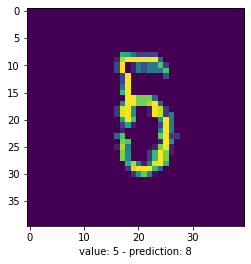

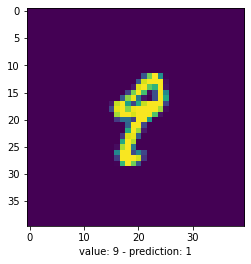

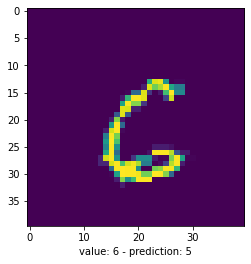

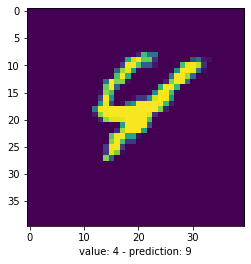

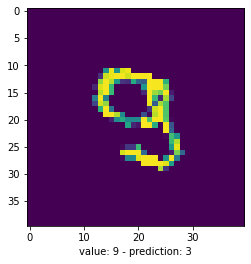

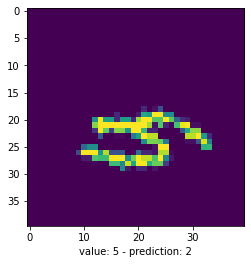

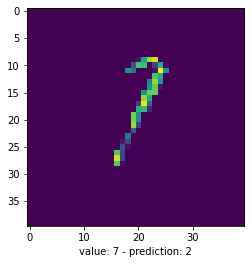

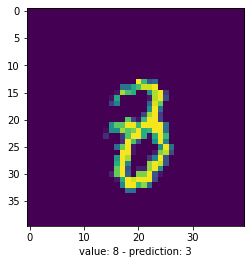

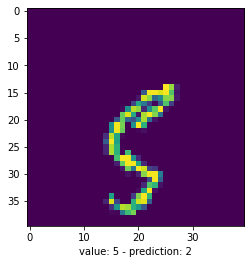

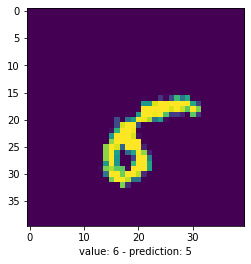

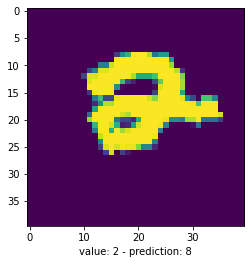

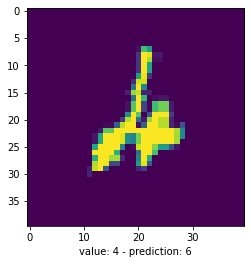

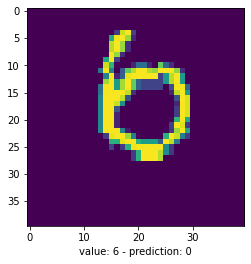

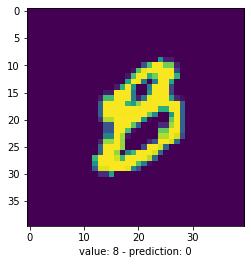

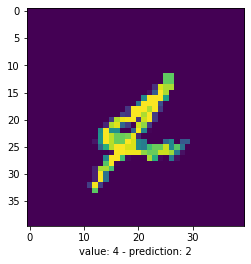

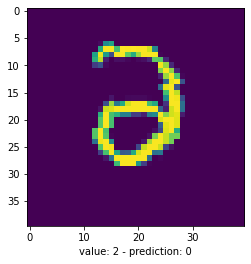

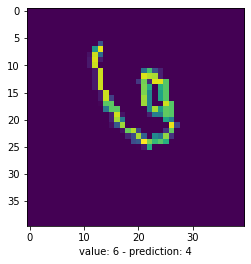

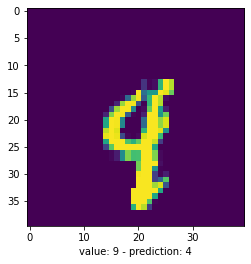

In [5]:
errors = [45, 78, 98, 139, 151, 167, 175, 184, 211, 217, 222, 247, 259, 266, 300, 318, 341, 359]

for i in errors:
    show_prediction(i)


In [ ]:
show_network(45)

In [ ]:
show_fixed_network_params()